<!-- # Variable elimination algorithm -->

# An API for belief networks in python
## Implementing the *varaible elimination algorithm*

* Download, unzip, and cd in the file `elimination.zip`
* Open a new notebook in the same directory
* Add the follwing line at the beginning of the code

```python
from library.elimination import BeliefNetwork
```



Let's consider the network in the figure below:

[image goes here]


The network is created node by node using dictionaries as follows:

```python
A = {
    'ID':'A', # must be unique
    'Name':'Winter',
    'Description':'A longer description or comment',
    'Parents':[],
    'CPT':[0.6],
}
B = {
    'ID':'B',
    'Name':'Drizzle',
    'Description':'',
    'Parents':['A'],
    'CPT':[0.2,0.75],
}
C = {
    'ID':'C',
    'Name':'Rain',
    'Description':'',
    'Parents':['A'],
    'CPT':[0.8,0.1],  # C True
}
D = {
    'ID':'D',
    'Name':'Wet grass',
    'Description':'',
    'Parents':['B','C'],
    'CPT':[0.95,0.9,0.8,0.0], # D True
}
E = {
    'ID':'E',
    'Name':'Slippery road',
    'Description':'',
    'Parents':['C'],
    'CPT':[0.7,0.0],  # E True
}
```

The key `'Parent'` in the above node dictionaries define the architecture of the network.

The CPT values are those associated with the `True` states of the node variable. With more than two parents this may need additional specifications for the user. 

In [39]:
from library.elimination import BeliefNetwork

In [40]:
BN = BeliefNetwork(A,B,C,D,E)

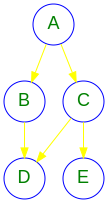

In [41]:
BN.displayGraph()

The joint probability distribution can be obtained multiplying at once all the factors associated with the CPT of each node.

`P(A, B, C, D, E) = P(A) * P(B|A) * P(C|A) * P(D|BC) * P(E|C)`

From the above joint distribution we any further query on the network can be performed. For example we could ask what is the marginal distribution P(E). This will be done by summing out all the variables except E from the joint P(A, B, C, D, E).


Because this network is small, the joint distribution can be explicitly displayed. The full joint distribution can be computed as follows:

In [42]:
jointALL = BN.joint('A','B','C','D','E')

In [43]:
jointALL.show()

,A,B,C,D,E,"f(A,B,C,D,E)"
1,True,True,True,True,True,0.06384
2,True,True,True,True,False,0.02736
3,True,True,True,False,True,0.00336
4,True,True,True,False,False,0.00144
5,True,True,False,True,True,0.00000
6,True,True,False,True,False,0.02160
7,True,True,False,False,True,0.00000
8,True,True,False,False,False,0.00240
9,True,False,True,True,True,0.21504
10,True,False,True,True,False,0.09216


We can apply the elimination algorithm directly to the joint and obtain the specific marginals or conditional probabilities.

For example we could ask for the joint probability `P(D,E)`, which can be obtained by summing out all of the variables not included in the query, i.e. `'A'`, `'B'`, `'C'`. The API has a method called `sumout` to perform this task.

In [44]:
(((jointALL.sumout('A')).sumout('B')).sumout('C')).show()

,D,E,"f(D,E)"
1,True,True,0.30443
2,True,False,0.39507
3,False,True,0.05957
4,False,False,0.24093


Obtaining the joint `P(D,E)` is not very efficient in this way. This is because the full joint probability is the largest factor that appear in the network. 

So we can obtain the same result in a more efficient way, deploying the *Variable Elimination* algorithm. This is becuase the VE algorithm looks for the combination of factors that minimizes the size of factors involved and therefore the number of arithmetic operations. 

The API performs this task automatically using the following syntax:

In [45]:
BN.joint('D','E').show()

,E,D,"f(E,D)"
1,True,True,0.30443
2,True,False,0.05957
3,False,True,0.39507
4,False,False,0.24093


Alternatively the same query can be invoked with some more syntactic sugar as follwos:

In [46]:
(BN.n['D'] & BN.n['E']).show()

,E,D,"f(E,D)"
1,True,True,0.30443
2,True,False,0.05957
3,False,True,0.39507
4,False,False,0.24093


What has the elimination algorithm done to get this result? 

It has gone through all of the permuations of the set `{'A','C','B'}` and has selected the most efficient combination of these variables, which in this case happens to be `['A','B','C']`. This combination means that the algorithm sumout variable `'A'` first, so (1) it looks for all the CPTs that contain the variable A, (2) performs *factor multiplication* between them, and (3) sum out variable A from the resulting factor. 

factor_with_A := `P(A) * P(B|A) * P(C|A)`

Let's follow this process step by step. 

1. Collect all the CPTs where A appears:

In [47]:
BN.f['A']  # P(A)

('A',): f(A)
(True,): 0.6
(False,): 0.4

In [48]:
BN.f['B']  # P(B|A)

('B', 'A'): f(B,A)
(True, True): 0.2
(True, False): 0.75
(False, True): 0.8
(False, False): 0.25

In [49]:
BN.f['C']  # P(C|A)

('C', 'A'): f(C,A)
(True, True): 0.8
(True, False): 0.1
(False, True): 0.19999999999999996
(False, False): 0.9

2. Perform factor multiplication between them:

The API implements the factor multiplication.

In [50]:
(BN.f['A'] * BN.f['B'] * BN.f['C']).show()

,A,B,C,"f(A,B,C)"
1,True,True,True,0.096
2,True,True,False,0.024
3,True,False,True,0.384
4,True,False,False,0.096
5,False,True,True,0.030
6,False,True,False,0.270
7,False,False,True,0.010
8,False,False,False,0.090


2. Ultimately variable A is eliminated:

In [51]:
(BN.f['A'] * BN.f['B'] * BN.f['C']).sumout('A').show()

,B,C,"f(B,C)"
1,True,True,0.126
2,True,False,0.294
3,False,True,0.394
4,False,False,0.186


We are left with the following factors:

`f(B,C) * P(D|BC) * P(E|C)`

Which clearly has no reference to the variable A.

We can now repeat this process for variable B and C. Noticing that:

```python
BN.f['D'] # P(D|BC)
BN.f['E'] # P(E|C)
```

Elimination of variable B:

In [52]:
fBC = (BN.f['A'] * BN.f['B'] * BN.f['C']).sumout('A')

((fBC * BN.f['D'] * BN.f['E']).sumout('B')).show()

,C,D,E,"f(C,D,E)"
1,True,True,True,0.30443
2,True,True,False,0.13047
3,True,False,True,0.05957
4,True,False,False,0.02553
5,False,True,True,0.00000
6,False,True,False,0.26460
7,False,False,True,0.00000
8,False,False,False,0.21540


Elimination of variable C:

In [53]:
fCDE = (fBC * BN.f['D'] * BN.f['E']).sumout('B')

Because there are no more factors, this will just require the marginalization of C.

In [54]:
(fCDE.sumout('C')).show()

,D,E,"f(D,E)"
1,True,True,0.30443
2,True,False,0.39507
3,False,True,0.05957
4,False,False,0.24093


## Conditional probability

Now we want to obtain the conditional probability `P(E|D)`.

This is not a trivial task, but can be done by normailizing the above factor with respect to E.  In this way learning the state of D will leave us with a probability mass for E.

The API performs this task in a friendly way

In [55]:
fDE = fCDE.sumout('C')

In [56]:
(fDE.normalize('E')).show()

,D,E,"f(D,E)"
1,True,True,0.435211
2,True,False,0.564789
3,False,True,0.198236
4,False,False,0.801764


The same result can be achived using--in a more Bayesian way--factor division after having computed the marginal distribution of D, in line with the formula:

`P(E|D) = P(D,E) / P(D)`

In [57]:
fD = BN.marginal('D')

In [58]:
(fDE / fD).show()

,D,E,"f(D,E)"
1,True,True,0.435211
2,True,False,0.564789
3,False,True,0.198236
4,False,False,0.801764


The API provides a direct access to conditional probability in two ways:

1. using the method `query`.

In [59]:
(BN.query('E', given=['D'])).show()

,D,E,"f(D,E)"
1,True,True,0.435211
2,True,False,0.564789
3,False,True,0.198236
4,False,False,0.801764


2. using the `or` operator to reflect the well-known notation.

In [60]:
(BN.n['E'] | [BN.n['D']]).show()

,D,E,"f(D,E)"
1,True,True,0.435211
2,True,False,0.564789
3,False,True,0.198236
4,False,False,0.801764


The API enables also more complex queries, i.e. involving multiple variables:

For example `P(E|C,D)`

In [63]:
(BN.n['E'] | [BN.n['D'],BN.n['C']]).show()

,D,C,E,"f(D,C,E)"
1,True,True,True,0.7
2,True,True,False,0.3
3,True,False,True,0.0
4,True,False,False,1.0
5,False,True,True,0.7
6,False,True,False,0.3
7,False,False,True,0.0
8,False,False,False,1.0
